0

Descriptive Statistics:
       Roller Slide ID  End Cap Winding Tube LE (Weight, g)  \
count       500.000000                           500.000000   
mean        250.500000                            50.034190   
std         144.481833                             4.906266   
min           1.000000                            33.793663   
25%         125.750000                            46.498463   
50%         250.500000                            50.063986   
75%         375.250000                            53.183916   
max         500.000000                            69.263657   

       End Cap Winding Tube LE (Roundness Bearing Point)  \
count                                         500.000000   
mean                                            0.847640   
std                                             0.089272   
min                                             0.622784   
25%                                             0.769292   
50%                                          

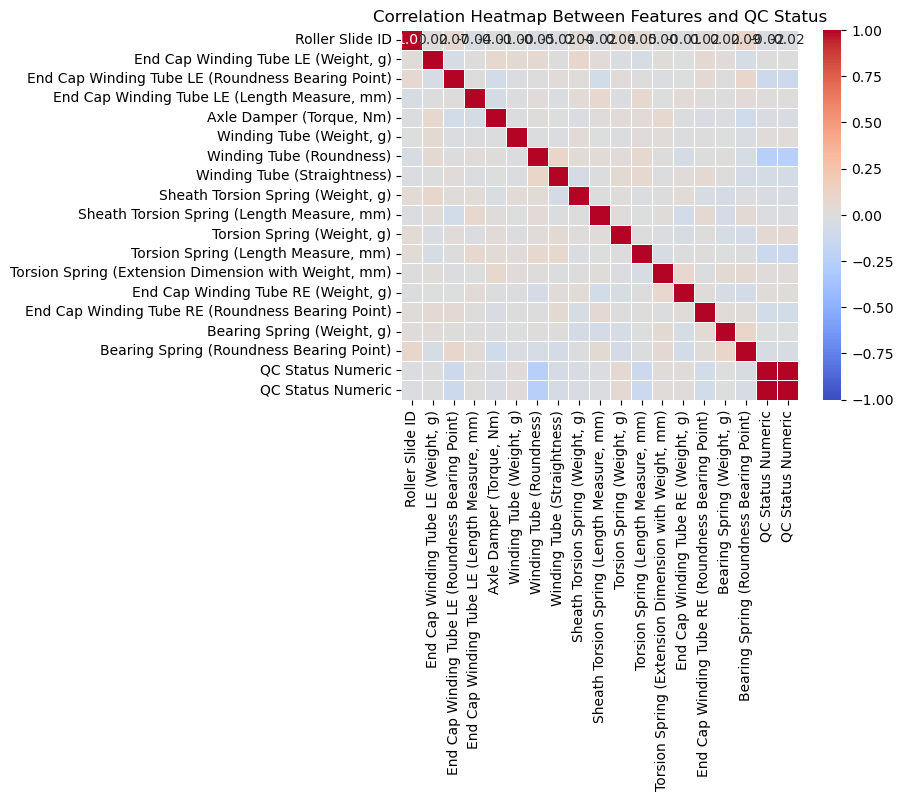

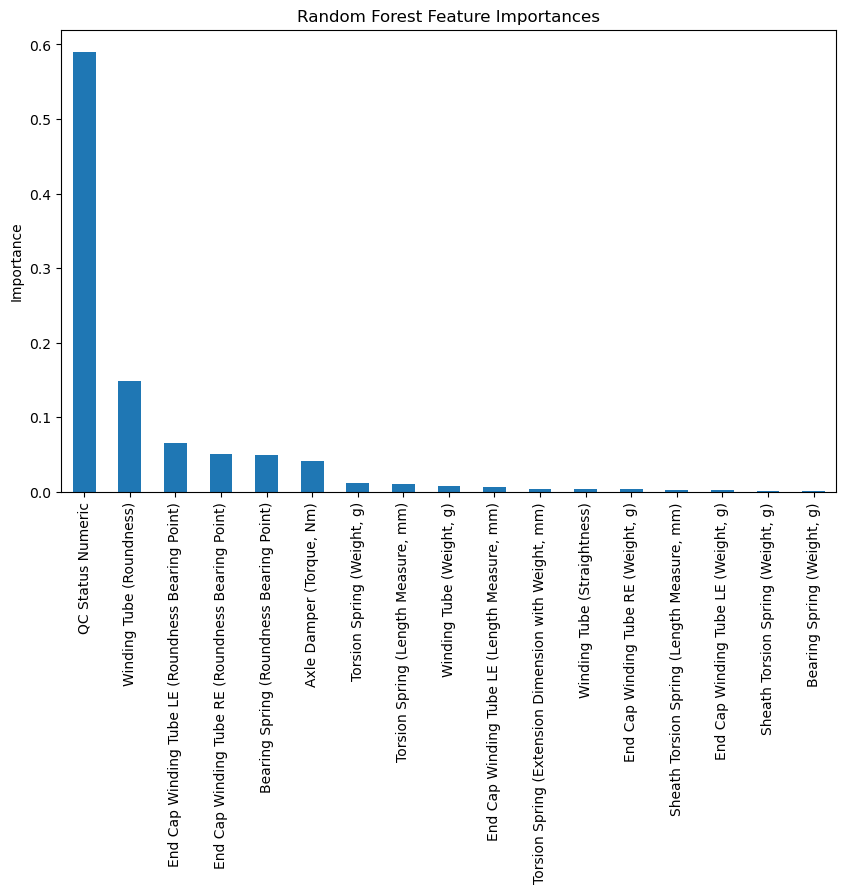

c:\Users\FATIMA BAIG\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


T-test p-values for each feature:
                                                         p_value
QC Status Numeric                                   0.000000e+00
Winding Tube (Roundness)                            1.405353e-08
Torsion Spring (Length Measure, mm)                 4.453972e-03
End Cap Winding Tube LE (Roundness Bearing Point)   6.185579e-03
End Cap Winding Tube RE (Roundness Bearing Point)   6.997492e-02
Torsion Spring (Weight, g)                          1.796560e-01
Winding Tube (Straightness)                         2.097558e-01
Bearing Spring (Roundness Bearing Point)            3.720176e-01
Sheath Torsion Spring (Weight, g)                   4.167774e-01
Axle Damper (Torque, Nm)                            4.723934e-01
Winding Tube (Weight, g)                            4.986654e-01
Torsion Spring (Extension Dimension with Weight...  5.690584e-01
Sheath Torsion Spring (Length Measure, mm)          7.000671e-01
End Cap Winding Tube RE (Weight, g)                 7.21

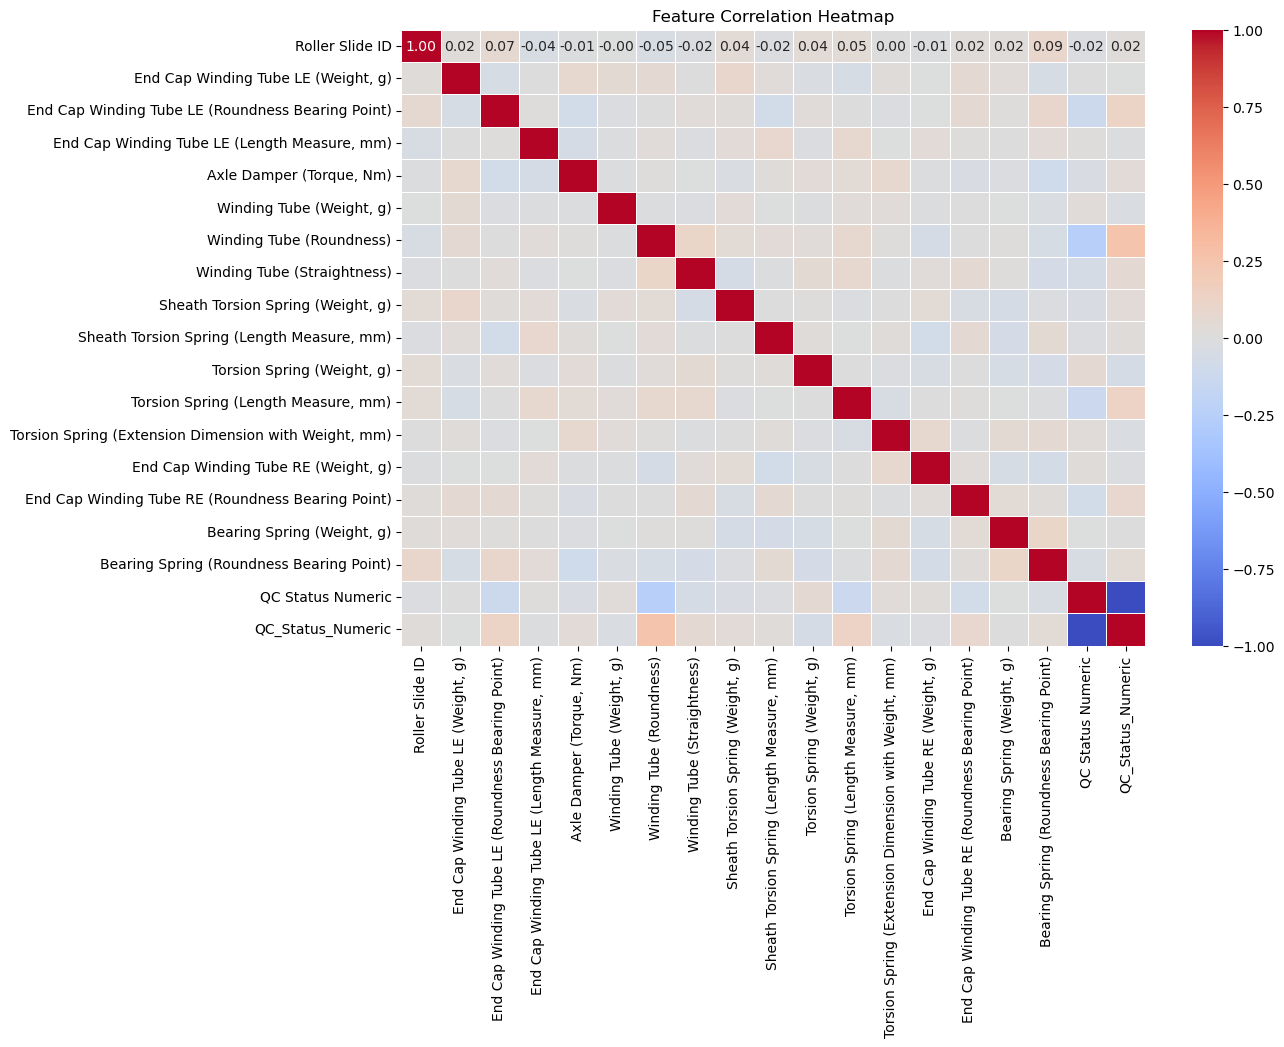

In [ ]:
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_ind
import shap
import numpy as np



df = pd.read_csv('../Data/roller_slide_assemblies.csv')

# print(df.isnull().sum())  # Count missing values per column
print(df.duplicated().sum())  # Count of duplicate rows
df_no_dupes = df.drop_duplicates()  # Drop duplicate rows

# Summary statistics for numerical columns
print("\nDescriptive Statistics:")
print(df.describe())

# Count occurrences of each QC Status
class_counts = df["QC Status"].value_counts().reset_index()
class_counts.columns = ["QC Status", "Count"]

# Create an Altair bar chart with tooltips
chart = alt.Chart(class_counts).mark_bar().encode(
    x=alt.X("QC Status", sort="-y", title="QC Status"),
    y=alt.Y("Count", title="Number of Samples"),
    color="QC Status",
    tooltip=["QC Status", "Count"]  # Add tooltips
).properties(
    title="QC Status Distribution",
    width=600,
    height=400
)

# Show the interactive chart
chart

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Box plots and histograms for each numeric column
box_plots = []
histograms = []

for column in numeric_columns:
    # Box Plot
    box_plot = alt.Chart(df).mark_boxplot().encode(
        alt.X(column, title=column),
        alt.Y('0:O', title='Box Plot'),
    ).properties(width=400, height=200)
    box_plots.append(box_plot)

    # Histogram
    histogram = alt.Chart(df).mark_bar().encode(
        alt.X(f'{column}:Q', bin=alt.Bin(maxbins=30), title=column),
        alt.Y('count():Q', title='Count')
    ).properties(width=400, height=200)
    histograms.append(histogram)

# Combine box plots and histograms vertically
box_plots = alt.hconcat(*box_plots)
histograms = alt.hconcat(*histograms)

# Display the plots
box_plots & histograms

# # Convert the QC Status column to numeric if it's categorical (e.g., 'Pass' -> 0, 'Fail' -> 1)
df['QC Status Numeric'] = df['QC Status'].apply(lambda x: 0 if x == 'Pass' else 1)

# # Select only numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

 #Calculate the correlation matrix for the numeric columns, including the converted 'QC Status Numeric'
corr_matrix = df[numeric_columns.tolist() + ['QC Status Numeric']].corr()

 # Create the heatmap using seaborn and matplotlib plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)

# Add title and display the plot
plt.title('Correlation Heatmap Between Features and QC Status')
plt.show()

df['QC Status Numeric'] = df['QC Status'].apply(lambda x: 0 if x == 'Pass' else 1)

# # ----------------------------
# # 3. Select Numeric Columns (Excluding duplicate QC Status Numeric)
# # ----------------------------
# # Get all numeric columns (this includes QC Status Numeric, so we drop it from the features)
#all_numeric = df.select_dtypes(include=['float64', 'int64']).columns
# # Exclude QC Status Numeric from the list for independent features:
#feature_cols = all_numeric.drop('QC Status Numeric', errors='ignore')

# # ----------------------------
# # 4. Create Scatter Plots
# # ----------------------------
#plt.figure(figsize=(15, 10))
#num_features = len(feature_cols)

#for i, col in enumerate(feature_cols):
# Calculate number of rows dynamically (3 plots per row)
#rows = (num_features + 2) // 3
#plt.subplot(rows, 3, i + 1)
#sns.scatterplot(data=df, x=col, y='QC Status Numeric', hue='QC Status Numeric', palette='coolwarm')
#plt.title(f'{col} vs QC Status')
#plt.tight_layout()

# plt.show()

# # ----------------------------
# # 5. Create a Pair Plot
# # ----------------------------
# # Build the DataFrame for pairplot: features plus the target variable (QC Status Numeric)
# pairplot_data = df[feature_cols.tolist() + ['QC Status Numeric']]
# sns.pairplot(pairplot_data, hue='QC Status Numeric', palette='coolwarm')
# plt.suptitle('Pair Plot: Feature Relationships with QC Status', y=1.02)
# plt.show()

# Define feature columns (exclude identifiers and the target)
feature_cols = [col for col in df.columns if col not in ['Roller Slide ID', 'QC Status', 'QC_Status_Numeric']]

# Prepare the data for modeling
X = df[feature_cols]
y = df['QC Status Numeric']

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get and plot feature importances
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.show()

# Separate the data by QC Status
passed = df[df['QC Status Numeric'] == 0]
failed = df[df['QC Status Numeric'] == 1]

ttest_results = {}
for col in feature_cols:
    # Compute the t-test comparing the two groups for each feature
    t_stat, p_val = ttest_ind(passed[col], failed[col], nan_policy='omit')
    ttest_results[col] = p_val

# Summarize the results in a DataFrame sorted by p-value
ttest_df = pd.DataFrame.from_dict(ttest_results, orient='index', columns=['p_value'])
ttest_df = ttest_df.sort_values('p_value')

print("T-test p-values for each feature:")
print(ttest_df)

# Step 2: Calculate SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# Step 3: For binary classification, shap_values is a list with 2 arrays (one for each class)
# Let's select the SHAP values for class 1 (positive class)
shap_to_plot = shap_values[1]  # Class 1 corresponds to the positive class in binary classification

# Step 4: Check the shape of the SHAP values to ensure they match `X`
print("Selected SHAP values shape:", np.array(shap_to_plot).shape)

# Step 5: Ensure that the shape of SHAP values matches the shape of the input data
# This check prevents plotting errors and ensures the correct values are used
if X.shape == np.array(shap_to_plot).shape:
    print("Shape match successful. Plotting SHAP summary.")
    # Step 6: Generate the SHAP summary plot
    shap.summary_plot(shap_to_plot, X)
else:
    print("Shape mismatch still exists. Please check the data and SHAP values.")
#A correlation heatmap helps identify relationships between features and failures.

# Convert QC Status to numeric (1 = Pass, 0 = Fail)
df['QC_Status_Numeric'] = df['QC Status'].apply(lambda x: 1 if x == 'Pass' else 0)

# Compute correlation matrix
corr_matrix = df.drop(columns=['QC Status']).corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()